In [4]:
import pyvinecopulib as pvcl

import numpy as np
import pandas as pd
import scipy.interpolate as interpolate
import scipy.optimize as optimize

import datetime
import pandas_datareader as pdr

import seaborn
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# pull financial data
start = datetime.datetime(2016,1,1)
end = datetime.datetime(2017,1,1) # datetime.date.today()
symbols = ["AAPL", "IBM", "GOOGL", "AMZN"]
panel = pdr.get_data_yahoo(symbols, start, end).transpose(1,0,2)
df = panel.to_frame().xs('Close', axis=0, drop_level=True)
df

Date,2016-01-04 00:00:00,2016-01-05 00:00:00,2016-01-06 00:00:00,2016-01-07 00:00:00,2016-01-08 00:00:00,2016-01-11 00:00:00,2016-01-12 00:00:00,2016-01-13 00:00:00,2016-01-14 00:00:00,2016-01-15 00:00:00,...,2016-12-16 00:00:00,2016-12-19 00:00:00,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00
minor,,,,,,,,,,,,,,,,,,,,,
AAPL,105.349998,102.709999,100.699997,96.449997,96.959999,98.529999,99.959999,97.389999,99.519997,97.129997,...,115.970001,116.639999,116.949997,117.059998,116.290001,116.519997,117.260002,116.760002,116.730003,115.820000
AMZN,636.989990,633.789978,632.650024,607.940002,607.049988,617.739990,617.890015,581.809998,593.000000,570.179993,...,757.770020,766.000000,771.219971,770.599976,766.340027,760.590027,771.400024,772.130005,765.150024,749.869995
GOOGL,759.440002,761.530029,759.330017,741.000000,730.909973,733.070007,745.340027,719.570007,731.390015,710.489990,...,809.840027,812.500000,815.200012,812.200012,809.679993,807.799988,809.929993,804.570007,802.880005,792.450012
IBM,135.949997,135.850006,135.169998,132.860001,131.630005,133.229996,132.899994,131.169998,132.910004,130.029999,...,166.729996,166.679993,167.600006,167.330002,167.059998,166.710007,167.139999,166.190002,166.600006,165.990005


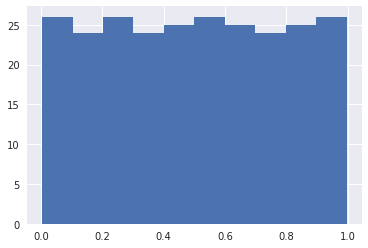

In [9]:
# log returns
returns = np.log(df).diff(axis=1).ix[:,1:]

def empirical_cdf(data):
    return data.dropna().rank(axis=1) / (len(data.columns) + 1) ####remove the +1 and test

# empirical cdf
emp = empirical_cdf(returns)

# empirical cdf histogram
emp.iloc[0,:].hist(bins=10)

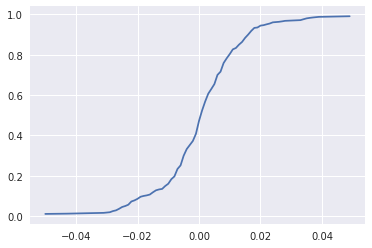

In [11]:
# empirical cdf plot 
cdf = interpolate.interp1d(returns.iloc[0,:], emp.iloc[0,:], fill_value="extrapolate")
x = np.arange(-.05, .05, 0.001)
y = cdf(x)
plt.plot(x, y)
plt.show()

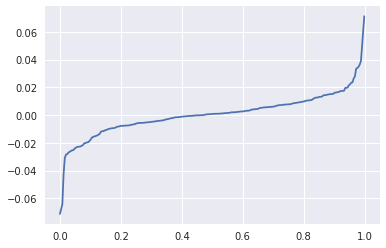

In [13]:
# inverse cdf
def inverse_cdf(cdf, y):
    def func(x):
        return cdf(x) - y
    return optimize.bisect(func, -1, 1)

v_inverse_cdf = np.vectorize(inverse_cdf)

# inverse empirical cdf plot
x = np.arange(0., 1., 0.001)
y = v_inverse_cdf(cdf, x)
plt.plot(x, y)
plt.show()

In [14]:
# fit general vine copula
pvcl.vinecop(emp.values)

In [15]:
# fit vine copula with controls
fitted = pvcl.vinecop(4)

fit_controls = pvcl.vinecop_fit_controls()
fit_controls.family_set = [
    pvcl.bicop_family.indep,
    pvcl.bicop_family.gaussian,
    pvcl.bicop_family.student,
    pvcl.bicop_family.clayton,
    pvcl.bicop_family.gumbel,
    pvcl.bicop_family.frank,
]
fit_controls.truncation_level = 2

fitted.select_all(emp.values, fit_controls)

In [16]:
# access vine copula attributes
print(fitted.matrix)
print(fitted.matrix[2,1])
print(fitted.family(0,2))
print(fitted.parameters(0,2))
print(fitted.rotation(0,2))

[[3 4 1 2]
 [3 1 4 0]
 [1 3 0 0]
 [1 0 0 0]]
3
gumbel
[1.5542758286705793]
180


In [32]:
# simulate from vine copula
num_draws = 250
sim_unif = pd.DataFrame(fitted.simulate(num_draws), index=df.index.values)
sim_unif

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
AAPL,0.784063,0.978002,0.081686,0.731791,0.249046,0.467404,0.689228,0.583055,0.742392,0.103327,...,0.772851,0.669208,0.384781,0.524572,0.219688,0.010971,0.824188,0.370487,0.383032,0.663721
AMZN,0.648461,0.822437,0.028457,0.953623,0.123470,0.390730,0.420414,0.120189,0.964653,0.045177,...,0.918131,0.504771,0.182248,0.832318,0.270100,0.001761,0.913771,0.484228,0.686763,0.460603
GOOGL,0.896122,0.938539,0.037263,0.902648,0.052924,0.793023,0.622252,0.085481,0.851882,0.042209,...,0.821008,0.790257,0.469157,0.263358,0.293195,0.001636,0.894591,0.620137,0.698347,0.355425
IBM,0.760488,0.889618,0.738091,0.756237,0.981837,0.675930,0.403680,0.073865,0.927156,0.213356,...,0.617656,0.666914,0.045002,0.469929,0.430027,0.043547,0.938365,0.355734,0.280082,0.184549


In [33]:
# flip uniform marginals into returns
sim_returns = sim_unif.copy()

for i in range(len(df.index)):
    cdf = interpolate.interp1d(returns.iloc[i,:], emp.iloc[i,:], fill_value="extrapolate")
    sim_returns_slice = v_inverse_cdf(cdf, sim_unif.iloc[i,:])
    sim_returns.iloc[i,:] = sim_returns_slice

sim_returns

,0,1,2,3,4,5,6,7,8,9,...,240,241,242,243,244,245,246,247,248,249
AAPL,0.009063,0.034331,-0.020339,0.007408,-0.006193,-0.000089,0.005836,0.002184,0.007623,-0.016769,...,0.008686,0.005494,-0.001585,0.001020,-0.007555,-0.048181,0.010754,-0.002163,-0.001594,0.005320
AMZN,0.005664,0.012551,-0.039195,0.026833,-0.015570,-0.003225,-0.001414,-0.015707,0.033122,-0.030691,...,0.021735,0.000965,-0.010276,0.013134,-0.006601,-0.086600,0.021144,0.000403,0.006793,0.000108
GOOGL,0.014322,0.016940,-0.025487,0.014639,-0.022979,0.009141,0.003180,-0.015583,0.012223,-0.024351,...,0.010002,0.009029,-0.000505,-0.004793,-0.003773,-0.063461,0.014206,0.003142,0.005770,-0.002676
IBM,0.007317,0.014580,0.006968,0.007162,0.026835,0.005223,-0.001580,-0.015463,0.016841,-0.006835,...,0.003739,0.005011,-0.019489,0.000212,-0.000738,-0.019697,0.017816,-0.002563,-0.004317,-0.007566


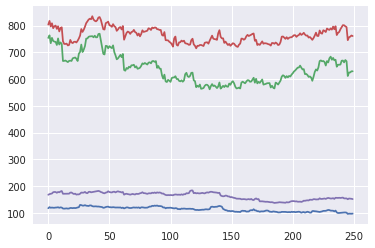

In [34]:
# flip simulated returns into underlying price paths
cum_returns = np.cumsum(sim_returns, axis=1)
temp = (cum_returns.transpose() + np.log(df.ix[:,-1])).transpose()
price_paths = np.exp(temp)

for i in range(4):
    plt.plot(price_paths.ix[i,:])

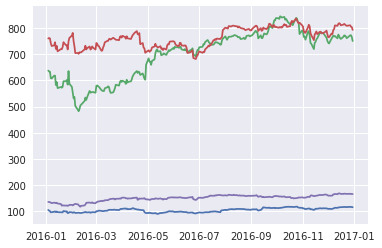

In [35]:
# compare with the original price path
for i in range(4):
    plt.plot(df.ix[i,:])